#Moving average crossover strategy

In [1]:
import datetime
import quandl
from abc import ABCMeta, abstractmethod
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pandas_datareader import DataReader
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
class Strategy(object):
    """Strategy is an abstract base class providing an interface for
    all subsequent (inherited) trading strategies.

    The goal of a (derived) Strategy object is to output a list of signals,
    which has the form of a time series indexed pandas DataFrame.

    In this instance only a single symbol/instrument is supported."""

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_signals(self):
        """An implementation is required to return the DataFrame of symbols 
        containing the signals to go long, short or hold (1, -1 or 0)."""
        raise NotImplementedError("Should implement generate_signals()!")

In [15]:
class Portfolio(object):
    """An abstract base class representing a portfolio of 
    positions (including both instruments and cash), determined
    on the basis of a set of signals provided by a Strategy."""

    __metaclass__ = ABCMeta

    @abstractmethod
    def generate_positions(self):
        """Provides the logic to determine how the portfolio 
        positions are allocated on the basis of forecasting
        signals and available cash."""
        raise NotImplementedError("Should implement generate_positions()!")

    @abstractmethod
    def backtest_portfolio(self):
        """Provides the logic to generate the trading orders
        and subsequent equity curve (i.e. growth of total equity),
        as a sum of holdings and cash, and the bar-period returns
        associated with this curve based on the 'positions' DataFrame.

        Produces a portfolio object that can be examined by 
        other classes/functions."""
        raise NotImplementedError("Should implement backtest_portfolio()!")

In [16]:
class MovingAverageCrossStrategy(Strategy):
    """    
    Requires:
    symbol - A stock symbol on which to form a strategy on.
    bars - A DataFrame of bars for the above symbol.
    short_window - Lookback period for short moving average.
    long_window - Lookback period for long moving average."""

    def __init__(self, symbol, bars, short_window=100, long_window=200):
        self.symbol = symbol
        self.bars = bars

        self.short_window = short_window
        self.long_window = long_window

    def generate_signals(self):
        """Returns the DataFrame of symbols containing the signals
        to go long, short or hold (1, -1 or 0)."""
        signals = pd.DataFrame(index=self.bars.index)
        signals['signal'] = 0.0

        # Create the set of short and long simple moving averages over the 
        # respective periods
        signals['short_mavg'] = pd.rolling_mean(self.bars['Close'], self.short_window, min_periods=1)
        signals['long_mavg'] = pd.rolling_mean(self.bars['Close'], self.long_window, min_periods=1)

        # Create a 'signal' (invested or not invested) when the short moving average crosses the long
        # moving average, but only for the period greater than the shortest moving average window
        signals['signal'][self.short_window:] = np.where(signals['short_mavg'][self.short_window:] 
            > signals['long_mavg'][self.short_window:], 1.0, 0.0) 
        # in above code where(condition, [x, y])

         #Return elements, either from `x` or `y`, depending on `condition`.


        #print signals['signal'][self.short_window:]

        # Take the difference of the signals in order to generate actual trading orders
        signals['positions'] = signals['signal'].diff()   
        #>>> x = np.array([1, 2, 4, 7, 0])
        # >>> np.diff(x)
        #array([ 1,  2,  3, -7])

        #print signals
        return signals
        

In [17]:
class MarketOnClosePortfolio(Portfolio):
    """Encapsulates the notion of a portfolio of positions based
    on a set of signals as provided by a Strategy.

    Requires:
    symbol - A stock symbol which forms the basis of the portfolio.
    bars - A DataFrame of bars for a symbol set.
    signals - A pandas DataFrame of signals (1, 0, -1) for each symbol.
    initial_capital - The amount in cash at the start of the portfolio."""

    def __init__(self, symbol, bars, signals, initial_capital=25000.0):
        self.symbol = symbol        
        self.bars = bars
        self.signals = signals
        self.initial_capital = float(initial_capital)
        self.positions = self.generate_positions()
        
    def generate_positions(self):
        positions = pd.DataFrame(index=self.signals.index).fillna(0.0)
        #fillna(0.0) fill not available value with 0.0
        positions[self.symbol] = 100 * self.signals['positions']   # This strategy buys 100 shares
        return positions
                    
    def backtest_portfolio(self):
        pf = pd.DataFrame(index=self.bars.index)
        #in above line  pf dataframe is being created having index same as bars
        pf['holdings'] = self.positions.mul(self.bars['Close'], axis='index')
        pf['cash'] = self.initial_capital - pf['holdings'].cumsum()     #cumsum() is cumulative sum
        pf['total'] = pf['cash'] + self.positions[self.symbol].cumsum() * self.bars['Close']
        #pct_change is percent change
        pf['returns'] = pf['total'].pct_change()

        return pf

C:\Program Files\Anaconda\lib\site-packages\ipykernel\__main__.py:24: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=10,center=False).mean()
C:\Program Files\Anaconda\lib\site-packages\ipykernel\__main__.py:25: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(min_periods=1,window=20,center=False).mean()


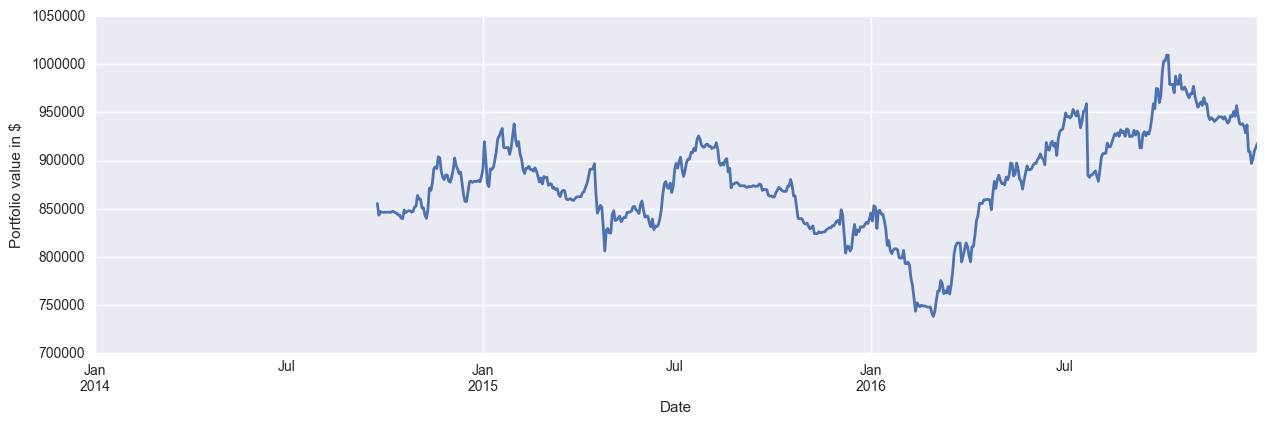

In [28]:
symbol='SBIN.NS'
bars=DataReader(symbol, "yahoo", datetime.datetime(2014, 1, 1), datetime.datetime(2017, 1, 1))
temp=pd.DataFrame(index=bars.index)
temp['total']=0
symbols=['IOC.NS','SAGCEM.NS','RELIANCE.NS','COALINDIA.NS','IGL.NS','ONGC.NS','VEDL.NS','GAIL.NS','TATASTEEL.NS','RAMCOCEM.NS','HINDZINC.NS','PETRONET.NS','UPL.NS','TATAPOWER.NS','HINDPETRO.NS','SHARDACROP.NS','HINDALCO.NS','NTPC.NS','EPCIN.BO','INDIACEM.NS','BIRLACORPN.NS','OIL.NS','BAYERCROP.NS','VINATIORGA.NS']
for symbol in symbols:
    #symbol=symbol
    bars=DataReader(symbol, "yahoo", datetime.datetime(2014, 1, 1), datetime.datetime(2017, 1, 1))
    mac = MovingAverageCrossStrategy(symbol, bars, short_window=50, long_window=100)
    signals = mac.generate_signals()
    #Create a portfolio of symbol, with $25000 initial capital
    portfolio = MarketOnClosePortfolio(symbol, bars, signals, initial_capital=25000.0)
    pf = portfolio.backtest_portfolio()
    temp['total']=pf['total']+temp['total']
    
#plotting the result    
fig = plt.figure(figsize=(15, 20))    
fig.patch.set_facecolor('white')     # Set the outer colour to white
    
    # Plot the equity curve in dollars
ax2 = fig.add_subplot(412, ylabel='Portfolio value in $')
temp['total'].plot(ax=ax2, lw=2.)

    

# Plot the figure
fig.show()    
    


In [29]:
print temp['total']

Date
2014-01-01           NaN
2014-01-02           NaN
2014-01-03           NaN
2014-01-06           NaN
2014-01-07           NaN
2014-01-08           NaN
2014-01-09           NaN
2014-01-10           NaN
2014-01-13           NaN
2014-01-14           NaN
2014-01-15           NaN
2014-01-16           NaN
2014-01-17           NaN
2014-01-20           NaN
2014-01-21           NaN
2014-01-22           NaN
2014-01-23           NaN
2014-01-24           NaN
2014-01-27           NaN
2014-01-28           NaN
2014-01-29           NaN
2014-01-30           NaN
2014-01-31           NaN
2014-02-03           NaN
2014-02-04           NaN
2014-02-05           NaN
2014-02-06           NaN
2014-02-07           NaN
2014-02-10           NaN
2014-02-11           NaN
                 ...    
2016-11-21    940658.338
2016-11-22    941963.337
2016-11-23    943583.238
2016-11-24    945688.338
2016-11-25    945443.338
2016-11-28    945338.238
2016-11-29    943118.238
2016-11-30    945488.288
2016-12-01    942228